In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rc('font', family='serif')
from scipy.optimize import curve_fit
from scipy.integrate import simps
import statsmodels.api as sm # import stats package
from scipy.optimize import curve_fit

## Define Functions

In [315]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(T, T_perturb, W, discount_function, gamma=2, D0=0.00267):
    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturb**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [316]:
## calculate abatement given a carbon price

def abatement(P, P0, P_h=44, r=20, s=18, Am=1.1):
    A = Am/(1+((P-P0)/P_h)**(-r/s))
    
    return A

In [317]:
## Nick's function to get SSP emissions data (use to get historical data to 2019)

def get_ssp_emissions(ssp, end_year = 2019):
    
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:end_year]

    ## rebase emission-driven forcings & species with natural emissions included in RCMIP to zero @ 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]
    
    return emms

In [318]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [319]:
def create_total_consumption(first_year, last_historical_year, years, T_forecast, T_2019, T_forecast_years, g_2019, g_grad):
    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)
    W_2019 = 80
    
    W = []

    W_historical = [W_2019] * (last_historical_year - first_year + 1)

    W_forecast = []

    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [320]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [321]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [322]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [323]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

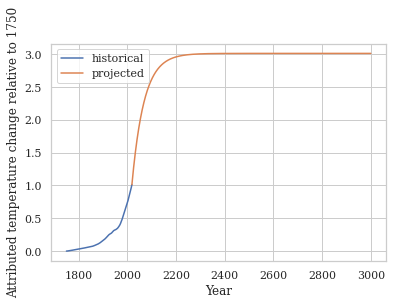

In [324]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Create Perturbed Temperature Profile (here just for first year)

In [325]:
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

In [326]:
T_TCRE = 0.00054  # need to check this for FAIR!
k_s = 0.12

T_p = np.zeros(T_forecast_length)
for i in range(len(T_forecast_years)):
    if year_of_perturbation[0] <= T_forecast_years[i]:
        T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[0])))
T_forecast_perturbed = T_forecast+T_p
T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

In [327]:
# plt.plot(T_forecast_years, T_forecast_perturbed)
# plt.plot(T_forecast_years, T_forecast)
# plt.xlim(2000, 2100)
# plt.ylim(1, 1.5)

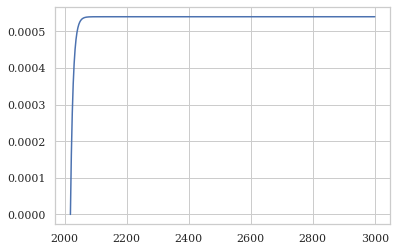

In [328]:
plt.plot(T_forecast_years, T_forecast_perturbed - T_forecast)

## Create g as a function of T

Calculate parameters using Pretis Paper

$W = W_{0}e^{g(T)t}$,

where $g(T)=g(0)-\alpha (T-T_{2019})$.

So $\frac{\Delta W}{W}=1-\exp((g(T)-g(0)t) \implies g(T) = g(0) + \frac{1}{t} \log(1-\frac{\Delta W}{W})$,

From Pretis paper (t=80):
- $T=1.5 \implies \frac{\Delta W}{W}=0.07 \implies \alpha = 0.000403170516$ 
- $T=2 \implies \frac{\Delta W}{W}=0.12 \implies \alpha = 0.000399479286$

Text(0, 0.5, 'g')

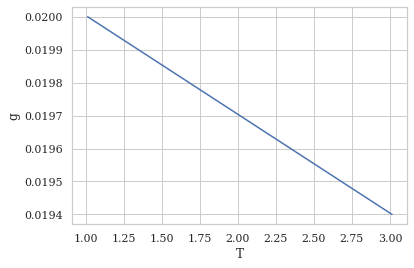

In [329]:
# g_2019 = 0.03
g_2019 = 0.02
# g_grad = 0.0003
# g_grad = 0.0013
g_grad = 0.0003
# g_grad = 0.0004

g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**1
g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
plt.plot(T_forecast[:-1], g)

plt.xlabel("T")
plt.ylabel("g")

Text(0, 0.5, 'g')

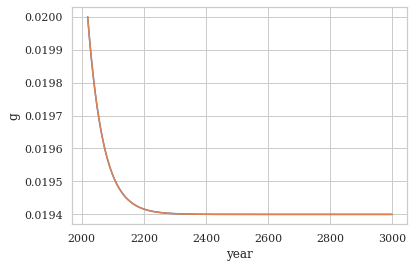

In [330]:
plt.plot(T_forecast_years[:-1], g)
plt.plot(T_forecast_years[:-1], g_prime)
plt.xlabel("year")
plt.ylabel("g")

Text(0, 0.5, 'g')

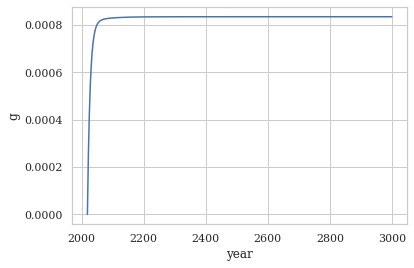

In [331]:
plt.plot(T_forecast_years[:-1], (g-g_prime)*100/g)
plt.xlabel("year")
plt.ylabel("g")

## Calculate SCC for first year

In [332]:
first_perturbed_year = last_historical_year
last_perturbed_year = 3000
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

W_2019 = 80

In [333]:
## consumption growth from unperturbed temperature profile

W = []
W_historical = [W_2019] * (last_historical_year - start_year + 1)
W_forecast = []
W_previous_year = W_historical[-1]

for i in range(len(T_forecast_years) - 1):
    W_this_year = W_previous_year*np.exp(g[i])
    W_forecast.append(W_this_year)
    W_previous_year = W_this_year

W = W_historical + W_forecast

W = np.asarray(W)

In [334]:
## consumption growth from perturbed temperature profile

W_prime = []
W_historical = [W_2019] * (last_historical_year - start_year + 1)
W_forecast = []
W_previous_year = W_historical[-1]

for i in range(len(T_forecast_years) - 1):
    W_this_year = W_previous_year*np.exp(g_prime[i])
    W_forecast.append(W_this_year)
    W_previous_year = W_this_year

W_prime = W_historical + W_forecast

W_prime = np.asarray(W_prime)

- constant baseline

$g(T)=g(0)$

In [335]:
# x = np.linspace(0, 0.5, len(T_forecast_years) - 1)

In [336]:
years_till_peak = 130
SSP2_T = np.concatenate((np.linspace(0, 0.5, years_till_peak), np.ones(len(T_forecast_years) - years_till_peak -1)*0.5), axis=None)

when year < year_of_peak, $T_{SSP}=(0.5/year.till.peak)(year-2019)$

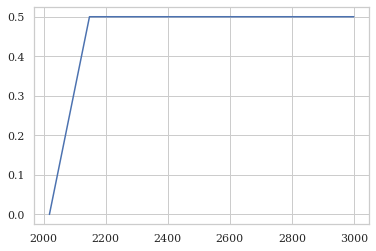

In [337]:
plt.plot(T_forecast_years[:-1], SSP2_T)

$g(T)=g(0)-\alpha \times (T_{SSP})^{2}$

In [338]:
## consumption growth from constant g with T=T_(2019)

W_const = []
W_historical = [W_2019] * (last_historical_year - start_year + 1)
W_forecast = []
W_previous_year = W_historical[-1]

for i in range(len(T_forecast_years) - 1):
    W_this_year = W_previous_year*np.exp(g_2019)
#     W_this_year = W_previous_year*np.exp(g_2019 - g_grad*(SSP2_T[i])**2)
    W_forecast.append(W_this_year)
    W_previous_year = W_this_year

W_const = W_historical + W_forecast

W_const = np.asarray(W_const)

$g(T)=g(0)-\alpha \times 1.5$

$g(T)=g(0)-\alpha \times (T_{SSP}+1.5)$

In [339]:
years_till_peak = 80
T_1pt5 = np.concatenate((np.linspace(0, 1.5, years_till_peak), np.ones(len(T_forecast_years) - years_till_peak-1)*1.5), axis=None)

In [340]:
## consumption growth from constant g with T=T_(2019)+1.5

W_const_1p5 = []
W_historical = [W_2019] * (last_historical_year - start_year + 1)
W_forecast = []
W_previous_year = W_historical[-1]

# g_1p5 = g_2019 - g_grad*(1.5)**2

for i in range(len(T_forecast_years) - 1):
#     W_this_year = W_previous_year*np.exp(g_1p5)
    W_this_year = W_previous_year*np.exp(g_2019 - g_grad*(T_1pt5[i])**1)
#     W_this_year = W_previous_year*np.exp(g_2019 - g_grad*(SSP2_T[i]+1.5)**2)
    W_forecast.append(W_this_year)
    W_previous_year = W_this_year

W_const_1p5 = W_historical + W_forecast

W_const_1p5 = np.asarray(W_const_1p5)

$g(T)=g(0)-\alpha \times 2^{2}$

$g(T)=g(0)-\alpha \times (T_{SSP}+2)^{2}$

In [341]:
T_1pt2 = np.concatenate((np.linspace(0, 2, years_till_peak), np.ones(len(T_forecast_years) - years_till_peak-1)*2), axis=None)

In [342]:
## consumption growth from constant g with T=T_(2019)+2

W_const_2 = []
W_historical = [W_2019] * (last_historical_year - start_year + 1)
W_forecast = []
W_previous_year = W_historical[-1]

# g_2 = g_2019 - g_grad*(2)**2

for i in range(len(T_forecast_years) - 1):
#     W_this_year = W_previous_year*np.exp(g_2)
    W_this_year = W_previous_year*np.exp(g_2019 - g_grad*(T_1pt2[i])**1)
#     W_this_year = W_previous_year*np.exp(g_2019 - g_grad*(SSP2_T[i]+2)**1)
    W_forecast.append(W_this_year)
    W_previous_year = W_this_year

W_const_2 = W_historical + W_forecast

W_const_2 = np.asarray(W_const_2)

- SSP2 ~ 2 degrees (FAIR); change TCRE
- temperature output with alpha value ~ 0.013
- GDP in two cases: 1) not sensitive to temperature 2) sensitive to temperature
- loss of GDP 

grea

In [343]:
# total annual consumption is higher in 2100 in the unperturbed case (obviously)
print(W[2100-start_year])
print(W_prime[2100-start_year])

394.54417302109954
394.5395610371836


In [344]:
# check compared to baseline

print(W_const[2100-start_year])
print(W_const_1p5[2100-start_year])
print(W_const_2[2100-start_year])

404.2472253251083
396.8572462046719
394.42406384534956


In [345]:
print((W_const[2100-start_year]-W_const_1p5[2100-start_year])/W_const[2100-start_year])

0.01828084067736791


In [346]:
percentage_change_1p5 = (W_const_1p5-W_const)/W_const
percentage_change_2 = (W_const_2-W_const)/W_const

In [347]:
len(W_const)

1251

In [348]:
# plt.plot(years, time_evolution)
# plt.title("1.5 Degrees Celsius Relative to No Additional Warming")
# plt.xlabel("Year")
# plt.ylabel("Percentage Change in GDP")
# plt.plot(years[2000-start_year:], time_evolution[2000-start_year:])

Text(0, 0.5, 'Percentage Change in GDP')

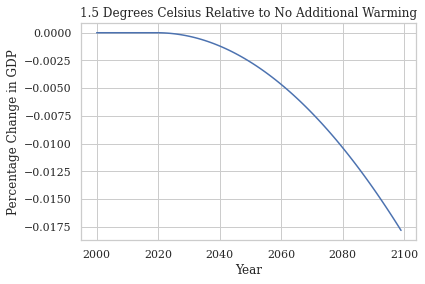

In [349]:
plt.plot(years[2000-start_year:2100-start_year], percentage_change_1p5[2000-start_year:2100-start_year])
plt.title("1.5 Degrees Celsius Relative to No Additional Warming")
plt.xlabel("Year")
plt.ylabel("Percentage Change in GDP")
# plt.plot(years[2000-start_year:], time_evolution[2000-start_year:])

In [350]:
print((W_const[2100-start_year]-W_const_2[2100-start_year])/W_const[2100-start_year])

0.024299885971656617


Text(0, 0.5, 'Percentage Change in GDP')

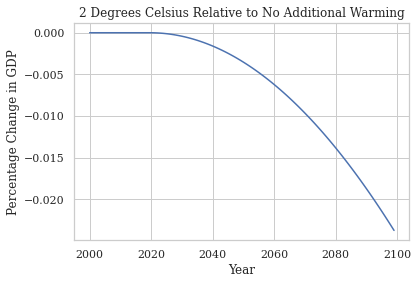

In [351]:
plt.plot(years[2000-start_year:2100-start_year], percentage_change_2[2000-start_year:2100-start_year])
plt.title("2 Degrees Celsius Relative to No Additional Warming")
plt.xlabel("Year")
plt.ylabel("Percentage Change in GDP")

In [313]:
print((W_const_1p5[2100-start_year]-W_const_2[2100-start_year])/W_const_1p5[2100-start_year])

0.006131127458530741


## Finishing off SCC calculation

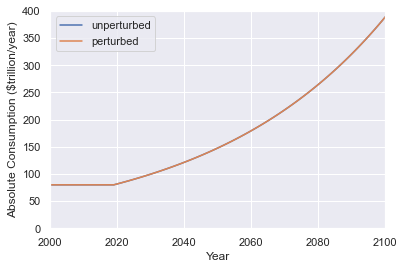

In [249]:
plt.plot(years, W, label="unperturbed")
plt.plot(years, W_prime, label="perturbed")
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
plt.xlim(2000, 2100)
plt.ylim(0, 400)
plt.legend()

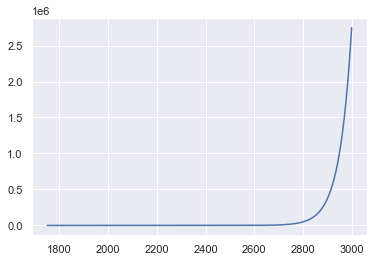

In [250]:
plt.plot(years, W-W_prime)

In [251]:
num_of_years = len(years)
# consumption_discount = 0.035
consumption_discount = g_2019 + 0.015
discount_function = np.zeros(num_of_years)

for i in range(num_of_years):
    if years[i] >= year_of_perturbation[0]:
        discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[0]))

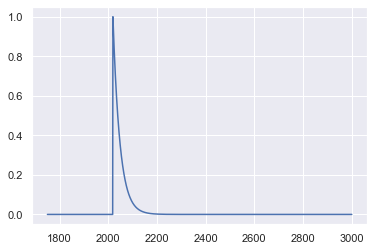

In [252]:
plt.plot(years, discount_function)

In [253]:
# T_p = np.zeros(T_forecast_length)
# for i in range(len(T_forecast_years)):
#     if year_of_perturbation[0] <= T_forecast_years[i]:
#         T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[0])))
# T_forecast_perturbed = T_forecast+T_p
# T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

In [254]:
# plt.plot(years, T)
# plt.plot(years, T_perturbed)

In [255]:
# plt.plot(years, T_perturbed-T)

Old SCC calculation because I was confused

In [256]:
# gamma=2
# D0=0.00267

# S_Wt = D0*T**gamma
# S_Wt_perturb = D0*T_perturbed**gamma

In [257]:
# # consumption_loss_fraction = S_Wt_perturb-S_Wt
# absolute_consumption_loss = S_Wt*W-S_Wt_perturb*W_prime
# discounted_consumption_loss = absolute_consumption_loss*discount_function
# area = simps(discounted_consumption_loss, dx=1)
# cost = area  # *10**12  # convert to dollar amount

In [258]:
# plt.plot(years, discounted_consumption_loss)

In [259]:
# cost

New SCC calculation??

In [260]:
absolute_consumption_loss = W-W_prime
discounted_consumption_loss = absolute_consumption_loss*discount_function
area = simps(discounted_consumption_loss, dx=1)
cost = area*10**12  # convert to dollar amount
SCC = cost/(10**9)

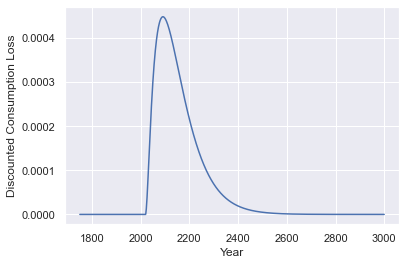

In [261]:
plt.xlabel("Year")
plt.ylabel("Discounted Consumption Loss")
plt.plot(years, discounted_consumption_loss)

In [262]:
SCC

77.00216986313396

for the growth-reduction case we obtain a much larger estimate for the SCC:
- this leads to problems in the method since P0 can exceed the value of P50, which causes the MACC curve to be undefined
- also the model struggles to converge when P0 is close to P_50/P_100 (particularly when close to P_100)

possible alterations:
- reduce the sensitivity of the growth rate to temperature (still within the uncertainty in Pretis)
- alter the MACC curves that are possible
- increase the discount rate

In [263]:
# absolute_consumption_loss = (W-W_prime)*D0
# discounted_consumption_loss = absolute_consumption_loss*discount_function
# area = simps(discounted_consumption_loss, dx=1)
# cost = area*10**12  # convert to dollar amount

In [264]:
# plt.plot(years, discounted_consumption_loss)

In [265]:
cost

77002169863.13396

## For all Years

In [57]:
T_TCRE = 0.00054  # need to check this for FAIR!
k_s = 0.12

T_p = np.zeros(T_forecast_length)
for i in range(len(T_forecast_years)):
    if year_of_perturbation[0] <= T_forecast_years[i]:
        T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[0])))
T_forecast_perturbed = T_forecast+T_p
T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

In [58]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


g_2019 = 0.02
g_grad = 0.0004

SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**2
    g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**2
    
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    
    
    W_prime = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g_prime[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W_prime = W_historical + W_forecast

    W_prime = np.asarray(W_prime)
    
    ## define discount function
    num_of_years = len(years)
    consumption_discount = 0.035
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    ## calculate SCC
#     cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
#     SCC = cost/(10**9)

    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    SCC = cost/(10**9)
    SCC_list.append(SCC)

In [59]:
SCC_array = np.asarray(SCC_list)

Text(0, 0.5, 'SCC ($)')

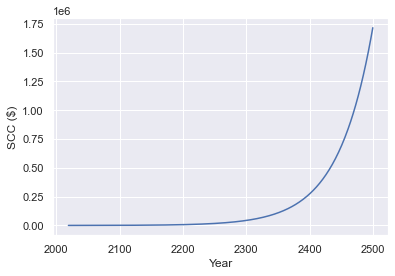

In [60]:
plt.plot(year_of_perturbation, SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

In [61]:
SCC_array[0]

146.3109629255208

Pretis style vs Nordhaus style damage function